In [ ]:
!pip install pandas
!pip install opencv-python numpy matplotlib


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


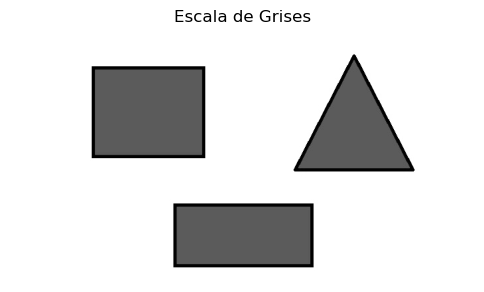

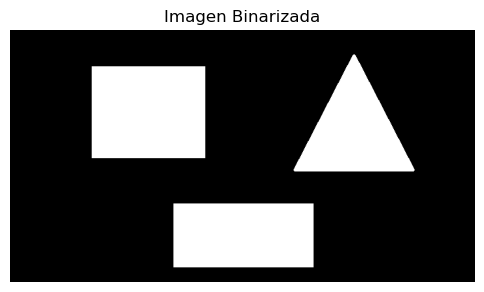

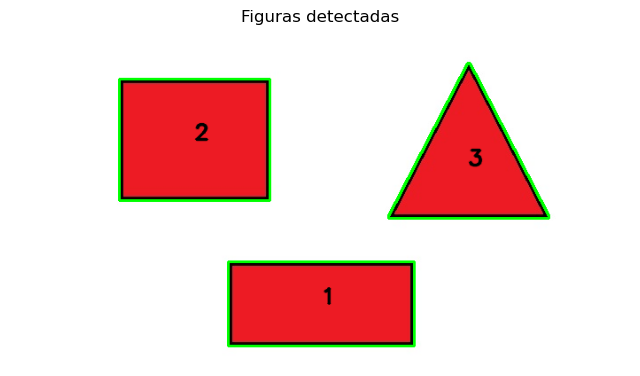

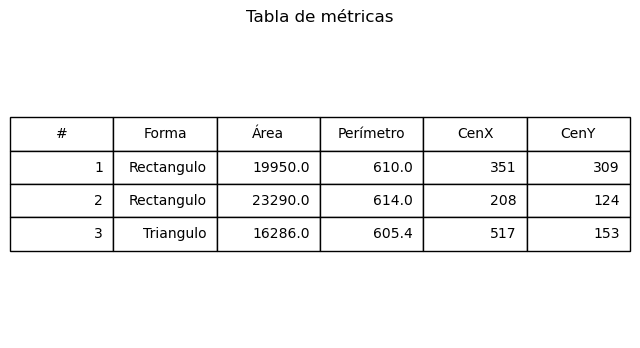

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# 1. Cargar una imagen binarizada
path = 'FormasNuevas.jpg'  # Cambia la ruta a tu imagen binarizada
img = cv2.imread(path)
if img is None:
    raise FileNotFoundError(f"No se encontró la imagen: {path}")

# Convertir a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Binarizar usando Otsu
_, binary_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Mostrar imagen en escala de grises
plt.figure(figsize=(6, 6))
plt.imshow(gray, cmap='gray')
plt.title('Escala de Grises')
plt.axis('off')
plt.show()

# Mostrar imagen binarizada
plt.figure(figsize=(6, 6))
plt.imshow(binary_otsu, cmap='gray')
plt.title('Imagen Binarizada')
plt.axis('off')
plt.show()

# Detectar contornos
contours, _ = cv2.findContours(binary_otsu, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Crear copia para dibujo
output = img.copy()

# Lista para almacenar métricas de cada figura
metrics = []

# 2. Calcular propiedades geométricas y clasificar las figuras
for idx, cnt in enumerate(contours, start=1):
    # Área y perímetro
    area = cv2.contourArea(cnt)
    peri = cv2.arcLength(cnt, True)

    # Calcular momentos y centroide
    M = cv2.moments(cnt)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        cx, cy = 0, 0

    # Aproximar polígono para clasificación de figura
    approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
    n_vertices = len(approx)
    if n_vertices == 3:
        shape = 'Triangulo'
    elif n_vertices == 4:
        # Distinguir cuadrado vs rectángulo por relación de aspecto
        x, y, w, h = cv2.boundingRect(approx)
        ar = w / float(h)
        shape = 'Cuadrado' if 0.95 <= ar <= 1.05 else 'Rectangulo'
    elif n_vertices > 4:
        shape = 'Circulo'
    else:
        shape = 'Desconocido'

    # Dibujar contorno
    cv2.drawContours(output, [cnt], -1, (0, 255, 0), 2)
    # Dibujar índice de figura junto al centroide
    cv2.putText(output, str(idx), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (0, 0, 0), 2, cv2.LINE_AA)
    # Guardar métricas para la tabla
    metrics.append([idx, shape, f"{area:.1f}", f"{peri:.1f}", cx, cy])

# Convertir las métricas a un DataFrame
df = pd.DataFrame(metrics, columns=['#', 'Forma', 'Área', 'Perímetro', 'CenX', 'CenY'])

# 3. Mostrar la imagen binarizada con los contornos detectados
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(output_rgb)
plt.title('Figuras detectadas')
plt.axis('off')
plt.show()

# 4. Crear una nueva imagen para la tabla
fig, ax = plt.subplots(figsize=(8, 4))  # Ajustar el tamaño de la figura
ax.axis('tight')  # Desactivar los ejes
ax.axis('off')  # Desactivar los ejes

# Crear la tabla
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax.set_title('Tabla de métricas')

# Guardar la tabla en una imagen
table_image_path = 'tabla_metrica.png'
plt.savefig(table_image_path, bbox_inches='tight', pad_inches=0.1)

# Mostrar la imagen de la tabla
table_image = Image.open(table_image_path)
table_image.show()
